In [16]:
import torch
import torch.nn as nn  # <-- Make sure this line is present.
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.nn.functional import sigmoid
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import re

In [2]:
# ---------- Device Setup ---------- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

✅ Using device: cuda


In [3]:
# ---------- Model Loading ---------- #
model_name = "sadickam/sdg-classification-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load the base model (assuming it comes with a 16-label classifier)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=16   # This model has been trained for 16 SDGs originally.
)
model = model.to(device)
model.train()

# ---------- Define SDG Labels ---------- #
sdg_labels = [
    "No Poverty", "Zero Hunger", "Good Health and Well-being", "Quality Education",
    "Gender Equality", "Clean Water and Sanitation", "Affordable and Clean Energy",
    "Decent Work and Economic Growth", "Industry, Innovation and Infrastructure",
    "Reduced Inequality", "Sustainable Cities and Communities", "Responsible Consumption and Production",
    "Climate Action", "Life Below Water", "Life on Land", "Peace, Justice and Strong Institutions",
    "Partnerships for the Goals"
]
# We now want to have 17 labels.
num_labels_new = len(sdg_labels)  # 17

# ---------- Expand the Classifier Head ----------
# Get the current classifier head's weights and biases
old_classifier = model.classifier  # This is a nn.Linear with shape [16, hidden_size]
old_weight = old_classifier.weight.data  # shape: [16, hidden_size]
old_bias = old_classifier.bias.data      # shape: [16]

hidden_size = model.config.hidden_size  # typically 768 for BERT-base

# Create new weight and bias tensors for 17 outputs
new_weight = torch.zeros((num_labels_new, hidden_size), device=old_weight.device)
new_bias = torch.zeros(num_labels_new, device=old_bias.device)

# Copy the first 16 rows from the old classifier weights/biases
new_weight[:16, :] = old_weight
new_bias[:16] = old_bias

# Initialize the 17th row for the additional SDG using Xavier normal initialization.
nn.init.xavier_normal_(new_weight[16:17, :])
# (new_bias[16] is already zero or you could initialize it explicitly if desired)

# ---------- Replace the Classifier Head ----------
# Create a new classifier head with 17 outputs and assign the new weights and biases.
model.classifier = nn.Linear(hidden_size, num_labels_new)
model.classifier.weight.data.copy_(new_weight)
model.classifier.bias.data.copy_(new_bias)

# Update the model configuration to reflect 17 labels.
model.config.num_labels = num_labels_new
model.config.problem_type = "multi_label_classification"


model = model.to(device)
model.train()

print("✅ Model is now modified with an expanded classifier head for 17 SDGs.")

✅ Model is now modified with an expanded classifier head for 17 SDGs.


In [4]:
# ---------- Data Preparation & Auto-labeling ---------- #
def build_text(row):
    parts = []
    for field in ['claims', 'abstract_text', 'title_en']:
        value = str(row.get(field, '')).strip()
        if value and value.lower() != 'nan':
            parts.append(value)
    ipc = str(row.get('ipc', '')).strip()
    if ipc and ipc.lower() != 'nan':
        parts.append(f"IPC: {ipc}")
    return " ".join(parts)

def auto_label(rows, threshold=0.5, confidence_limit=1.0):
    """
    For each row in the dataframe, build the input text and predict SDG scores.
    Rows that have a total confidence score >= confidence_limit are accepted,
    and their predictions are binarized based on the given threshold.
    """
    labeled = []
    binary_labels = []
    for _, row in tqdm(rows.iterrows(), total=len(rows)):
        text = build_text(row)
        if not text:
            continue
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
            probs = sigmoid(logits).squeeze().tolist()

        if isinstance(probs, float):
            probs = [probs]
        # Make sure the predicted probabilities match the number of SDG labels.
        if len(probs) < len(sdg_labels):
            probs += [0.0] * (len(sdg_labels) - len(probs))
        elif len(probs) > len(sdg_labels):
            probs = probs[:len(sdg_labels)]

        total_confidence = sum(probs)
        if total_confidence >= confidence_limit:
            binary = [1 if p > threshold else 0 for p in probs]
            binary_labels.append(binary)
            labeled.append(text)
    return labeled, binary_labels

In [5]:
# ---------- Dataset Class ---------- #
class SDGDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float32)
        }


In [6]:
# ---------- Improved Evaluation Metrics ---------- #
def compute_metrics(eval_pred):
    """
    Computes overall and per-SDG precision, recall, F1-scores,
    and confusion matrices from model predictions.
    """
    logits, labels = eval_pred
    probs = sigmoid(torch.tensor(logits))
    predictions = (probs > 0.5).int().numpy()
    labels = labels.astype(int)
    
    per_sdg_metrics = {}
    confusion_matrices = {}
    
    for idx, label_name in enumerate(sdg_labels):
        y_true = labels[:, idx]
        y_pred = predictions[:, idx]
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        cm = confusion_matrix(y_true, y_pred).tolist()
        
        per_sdg_metrics[label_name] = {
            "precision": precision,
            "recall": recall,
            "f1": f1
        }
        confusion_matrices[label_name] = cm

    overall_precision = precision_score(labels, predictions, average="micro", zero_division=0)
    overall_recall = recall_score(labels, predictions, average="micro", zero_division=0)
    overall_f1 = f1_score(labels, predictions, average="micro", zero_division=0)
    
    return {
        "overall_precision": overall_precision,
        "overall_recall": overall_recall,
        "overall_f1": overall_f1,
        "per_sdg": per_sdg_metrics,
        "confusion_matrices": confusion_matrices
    }


In [7]:
# ---------- Training Setup with Hugging Face Trainer ---------- #
training_args = TrainingArguments(
    output_dir="/home/jovyan/SDGClassification/models/epo_finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    logging_dir="/home/jovyan/SDGClassification/logs",
    logging_steps=100,
    save_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    #train_dataset=train_dataset,
    #eval_dataset=val_dataset,
    compute_metrics=compute_metrics   # <-- This should be your custom function.
)



In [8]:
# ---------- Live Predictions with Visualization ---------- #
def live_prediction(text, threshold=0.5):
    """
    Runs a live prediction on input text and displays a bar chart
    of confidence scores for each SDG.
    """
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = sigmoid(logits).squeeze().cpu().numpy()
    binary = (probs > threshold).astype(int)
    
    # Plot confidence scores for each SDG.
    plt.figure(figsize=(10, 6))
    plt.bar(sdg_labels, probs)
    plt.ylabel("Confidence Score")
    plt.title("Live SDG Prediction")
    plt.xticks(rotation=45, ha="right")
    plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return probs, binary


In [9]:
# ---------- Incremental Fine-tuning & Model Evolution Tracking ---------- #
def incremental_finetuning(data_batch_path, trainer, tokenizer, performance_history_path):
    """
    Fine-tunes the model on a new data batch loaded from a CSV file,
    updates the persistent performance history, and saves the model
    after the training round.
    
    Args:
      data_batch_path (str): Path to the CSV file containing the new data batch.
      trainer (Trainer): Hugging Face Trainer instance.
      tokenizer: The model’s tokenizer.
      performance_history_path (str): File path to store performance metrics history.
    
    Returns:
      Updated performance history DataFrame.
    """
    # Check for an existing performance history.
    if os.path.exists(performance_history_path):
        performance_df = pd.read_csv(performance_history_path)
        last_batch = performance_df["batch"].max()
    else:
        performance_df = pd.DataFrame(columns=["batch", "overall_precision", "overall_recall", "overall_f1"])
        last_batch = 0

    current_batch = last_batch + 1
    print(f"\n🔄 Starting Fine-tuning Round {current_batch} using data from: {data_batch_path}")
    
    # Load the new batch from the provided CSV.
    batch_df = pd.read_csv(data_batch_path)
    # Auto-label the new batch.
    new_texts, new_labels = auto_label(batch_df, threshold=0.5, confidence_limit=1.0)
    # 3. Convert to DataFrame and save to CSV
    labeled_df = pd.DataFrame(new_labels, columns=sdg_labels)
    labeled_df.insert(0, "text", new_texts)
    autolabel_path = "/home/jovyan/SDGClassification/data/epo_autolabeled.csv"
    labeled_df.to_csv(autolabel_path, index=False)
    print("✅ Auto-labeled data saved to epo_autolabeled.csv")

    # --- ✅ Append this block to correct SDG 17 using regex heuristics ---



    # Load the just-saved labeled dataset
    df = pd.read_csv(autolabel_path)

    # Broad regex patterns for SDG 17: Partnerships for the Goals
    sdg17_patterns = [
        r"\bpublic[-\s]?private partnership\b",
        r"\bPPP\b",
        r"\bNGO (collaboration|partnership)\b",
        r"\bmulti[-\s]?stakeholder (initiative|partnership)\b",
        r"\bintergovernmental cooperation\b",
        r"\bglobal (partnership|collaboration)\b",
        r"\binternational (cooperation|collaboration|network)\b",
        r"\btechnology (transfer|sharing|dissemination)\b",
        r"\bknowledge (sharing|exchange)\b",
        r"\bcapacity[-\s]?building\b",
        r"\btechnical assistance\b",
        r"\bSouth[-\s]?South cooperation\b",
        r"\bNorth[-\s]?South cooperation\b",
        r"\btriangular cooperation\b",
        r"\bforeign aid\b",
        r"\bofficial development assistance\b",
        r"\bdevelopment (aid|cooperation|finance)\b",
        r"\bWTO\b",
        r"\bTechnology Facilitation Mechanism\b",
        r"\b2030 Agenda\b",
        r"\bSDG (framework|targets)\b",
        r"\bshared infrastructure\b",
        r"\bjoint (initiative|venture|project)\b",
        r"\bGlobal Alliance\b",
        r"\bUNDP\b", r"\bUNESCO\b", r"\bUNICEF\b", r"\bWorld Bank\b", r"\bOECD\b"
    ]

    compiled_patterns = [re.compile(pat, re.IGNORECASE) for pat in sdg17_patterns]

    def detect_sdg17(text):
        if isinstance(text, str):
            return int(any(pat.search(text) for pat in compiled_patterns))
        return 0

    # Overwrite the SDG 17 column using regex-based detection
    df["Partnerships for the Goals"] = df["text"].apply(detect_sdg17)

    # Save corrected file (overwrite or save new path as needed)
    df.to_csv(autolabel_path, index=False)
    print("✅ SDG 17 labels corrected using heuristic rules.")
    
    if len(new_texts) == 0:
        print(f"⚠️ No valid data found in round {current_batch}. Skipping fine-tuning.")
        return performance_df

    # Split the new batch into training and validation sets (e.g., 80/20 split).
    X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(new_texts, new_labels, test_size=0.2, random_state=42)
    new_train_dataset = SDGDataset(X_train_new, y_train_new, tokenizer)
    new_val_dataset = SDGDataset(X_val_new, y_val_new, tokenizer)

    print(f"✅ Fine-tuning on Round {current_batch} with {len(new_train_dataset)} training samples...")
    # Update the Trainer's datasets.
    trainer.train_dataset = new_train_dataset
    trainer.eval_dataset = new_val_dataset

    # Fine-tune the model using the new data.
    trainer.train()

    # Evaluate after fine-tuning.
    eval_results = trainer.evaluate()
    print(f"📊 Evaluation Results after Round {current_batch}:")
    print(eval_results)
    
    # Save the performance metrics for this round.
    new_record = {
        "batch": current_batch,
        "overall_precision": eval_results.get("eval_overall_precision"),
        "overall_recall": eval_results.get("eval_overall_recall"),
        "overall_f1": eval_results.get("eval_overall_f1")
    }
    #performance_df = performance_df.append(new_record, ignore_index=True)
    performance_df = pd.concat([performance_df, pd.DataFrame([new_record])], ignore_index=True)

    performance_df.to_csv(performance_history_path, index=False)
    print(f"💾 Updated performance history saved to: {performance_history_path}")
    
    # Save the updated (fine-tuned) model for this round.
    model_save_path = f"/home/jovyan/SDGClassification/models/epo_finetuned_round_{current_batch}"
    trainer.save_model(model_save_path)
    print(f"💾 Model checkpoint saved to: {model_save_path}")
    
    return performance_df

In [10]:
# ---------- (Optional) SDG Distribution Function for Reuse ---------- #
def plot_sdg_distribution(labels, sdg_labels, title="SDG Distribution in Current Batch"):
    """
    Given a list of binary label lists, computes and plots the SDG distribution.
    Returns a DataFrame with counts per SDG.
    """
    labels_array = np.array(labels)
    distribution_counts = labels_array.sum(axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.barh(sdg_labels, distribution_counts)
    plt.xlabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    dist_df = pd.DataFrame({"SDG": sdg_labels, "Count": distribution_counts})
    return dist_df

In [ ]:
# ---------- Main Execution: Incremental Fine-tuning Rounds ---------- #
# This file will be updated with new data batches over time.
data_batch_path = "/home/jovyan/SDGClassification/data/cleaned_columns_output.csv"
# The performance history CSV keeps track of performance across rounds.
performance_history_path = "/home/jovyan/SDGClassification/data/performance_history.csv"

# Run incremental fine-tuning (repeat this step as you update the CSV with new batches).
performance_history = incremental_finetuning(data_batch_path, trainer, tokenizer, performance_history_path)



🔄 Starting Fine-tuning Round 1 using data from: /home/jovyan/SDGClassification/data/cleaned_columns_output.csv


100%|██████████| 216583/216583 [55:05<00:00, 65.53it/s] 


✅ Auto-labeled data saved to epo_autolabeled.csv
✅ SDG 17 labels corrected using heuristic rules.
✅ Fine-tuning on Round 1 with 173266 training samples...


Epoch,Training Loss,Validation Loss


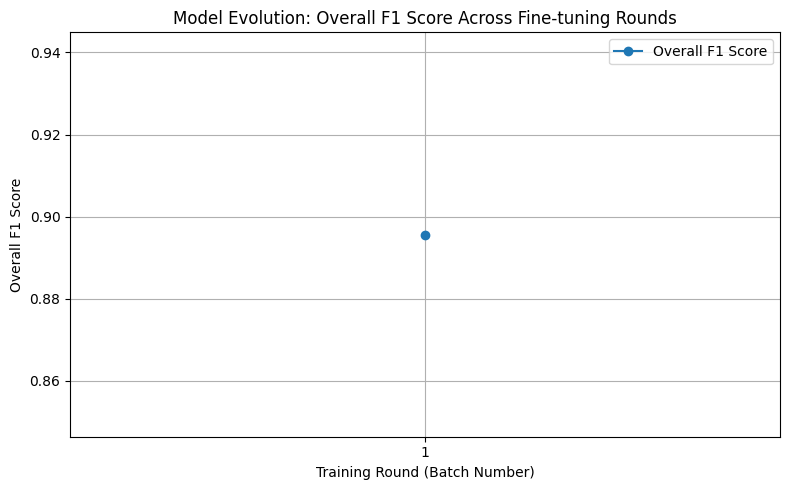

In [17]:
# Optionally, plot model evolution (Overall F1 Score) across training rounds.
if not performance_history.empty:
    batches = performance_history["batch"].astype(int).tolist()
    plt.figure(figsize=(8, 5))
    plt.plot(batches, performance_history["overall_f1"], marker="o", linestyle='-', label="Overall F1 Score")
    plt.xlabel("Training Round (Batch Number)")
    plt.ylabel("Overall F1 Score")
    plt.title("Model Evolution: Overall F1 Score Across Fine-tuning Rounds")
    plt.xticks(batches)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    


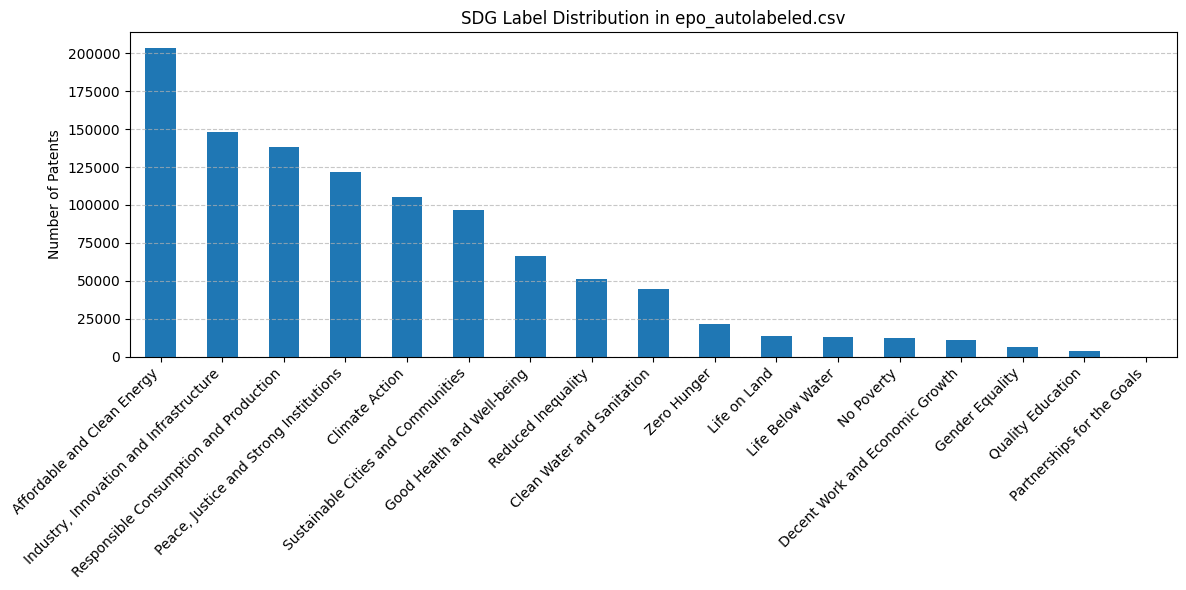

📊 SDG Distribution (based on already labeled data):
                                        SDG   Count
0               Affordable and Clean Energy  203662
1   Industry, Innovation and Infrastructure  148400
2    Responsible Consumption and Production  138249
3    Peace, Justice and Strong Institutions  121905
4                            Climate Action  105314
5        Sustainable Cities and Communities   96601
6                Good Health and Well-being   66214
7                        Reduced Inequality   51136
8                Clean Water and Sanitation   44867
9                               Zero Hunger   21159
10                             Life on Land   13372
11                         Life Below Water   12639
12                               No Poverty   12336
13          Decent Work and Economic Growth   10852
14                          Gender Equality    6061
15                        Quality Education    3990
16               Partnerships for the Goals       8


In [18]:
# ---------- SDG Distribution Visualization for Already Labeled Data ---------- #

# Load the already labeled dataset
data_path = "/home/jovyan/SDGClassification/data/epo_autolabeled.csv"
df = pd.read_csv(data_path)

# List of SDG columns (ensure this matches your CSV header exactly)
sdg_labels = [
    "No Poverty", "Zero Hunger", "Good Health and Well-being", "Quality Education",
    "Gender Equality", "Clean Water and Sanitation", "Affordable and Clean Energy",
    "Decent Work and Economic Growth", "Industry, Innovation and Infrastructure",
    "Reduced Inequality", "Sustainable Cities and Communities",
    "Responsible Consumption and Production", "Climate Action",
    "Life Below Water", "Life on Land", "Peace, Justice and Strong Institutions",
    "Partnerships for the Goals"
]

# Count label occurrences
label_counts = df[sdg_labels].sum().sort_values(ascending=False)

# Plot distribution
plt.figure(figsize=(12, 6))
label_counts.plot(kind="bar")
plt.title("SDG Label Distribution in epo_autolabeled.csv")
plt.ylabel("Number of Patents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Print label counts as a DataFrame
distribution_df = label_counts.reset_index()
distribution_df.columns = ["SDG", "Count"]
print("📊 SDG Distribution (based on already labeled data):")
print(distribution_df)


In [19]:
eval_results = trainer.evaluate()
print("Full Evaluation Results:")
print(eval_results)


Full Evaluation Results:
{'eval_loss': 0.14940808713436127, 'eval_overall_precision': 0.9056113949355842, 'eval_overall_recall': 0.8858766013308588, 'eval_overall_f1': 0.8956353002018279, 'eval_per_sdg': {'No Poverty': {'precision': 0.7866666666666666, 'recall': 0.6087494841106067, 'f1': 0.6863657515123314}, 'Zero Hunger': {'precision': 0.8446988551518169, 'recall': 0.8123504068932503, 'f1': 0.8282088823816496}, 'Good Health and Well-being': {'precision': 0.93823417961349, 'recall': 0.9380919906039251, 'f1': 0.9381630797211277}, 'Quality Education': {'precision': 0.7214673913043478, 'recall': 0.6645807259073843, 'f1': 0.6918566775244299}, 'Gender Equality': {'precision': 0.7272727272727273, 'recall': 0.467005076142132, 'f1': 0.5687789799072643}, 'Clean Water and Sanitation': {'precision': 0.8085622862186914, 'recall': 0.8257831868379536, 'f1': 0.8170820092546134}, 'Affordable and Clean Energy': {'precision': 0.9873993785324557, 'recall': 0.9916453705523884, 'f1': 0.989517819706499}, 'D

In [ ]:
# After an evaluation run (for example, after trainer.evaluate()):
eval_results = trainer.evaluate()
print("Overall Evaluation Metrics:")
print({
    "overall_precision": eval_results.get("eval_overall_precision"),
    "overall_recall": eval_results.get("eval_overall_recall"),
    "overall_f1": eval_results.get("eval_overall_f1")
})

# Extract per-SDG metrics from the evaluation results.
per_sdg_metrics = eval_results.get("eval_per_sdg")
if per_sdg_metrics is not None:
    # Convert the per-sdg dictionary to a DataFrame for nicer display.
    import pandas as pd
    df_per_sdg = pd.DataFrame(per_sdg_metrics).transpose()
    df_per_sdg.index.name = "SDG"
    print("\nPer-SDG Evaluation Metrics:")
    print(df_per_sdg)
else:
    print("No per-SDG metrics available.")


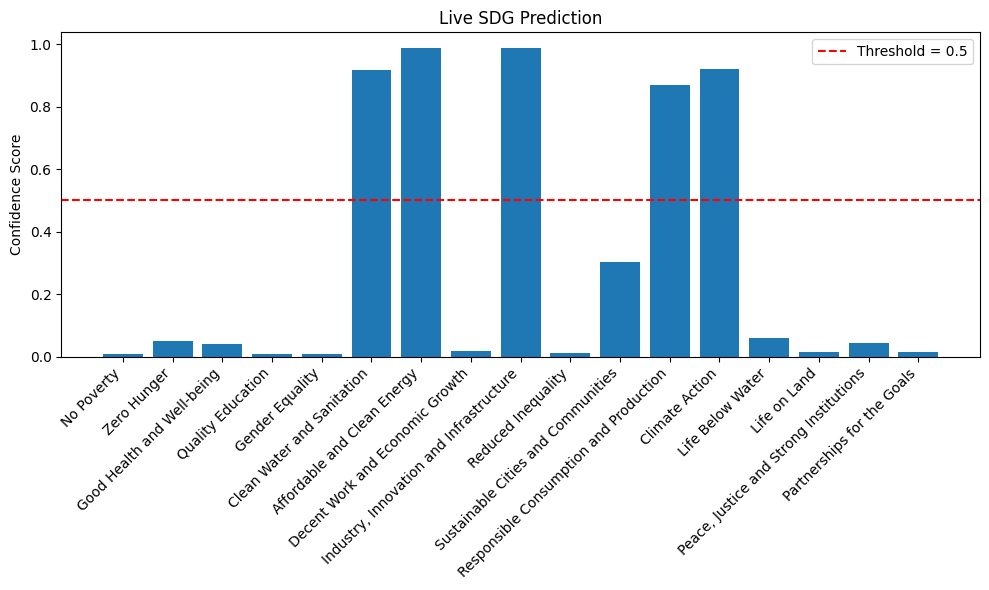

Confidence Scores: [0.00970838 0.04922074 0.03891551 0.00941346 0.00893345 0.91912735
 0.9889671  0.01658878 0.98804003 0.00987207 0.30375865 0.86985785
 0.919408   0.05953425 0.01412245 0.0421557  0.01448243]
Binarized Predictions: [0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0]


In [20]:
# ---------- Example Usage: Live Prediction ---------- #
sample_text = "This invention provides a compact, solar-powered desalination system designed for off-grid coastal or arid communities. The unit integrates photovoltaic panels with a high-efficiency reverse osmosis membrane and smart water flow controllers. It can produce up to 200 liters of potable water per day using only solar energy. The system includes automated cleaning cycles and remote diagnostics to reduce maintenance costs and downtime."
probabilities, binary_predictions = live_prediction(sample_text)
print("Confidence Scores:", probabilities)
print("Binarized Predictions:", binary_predictions)


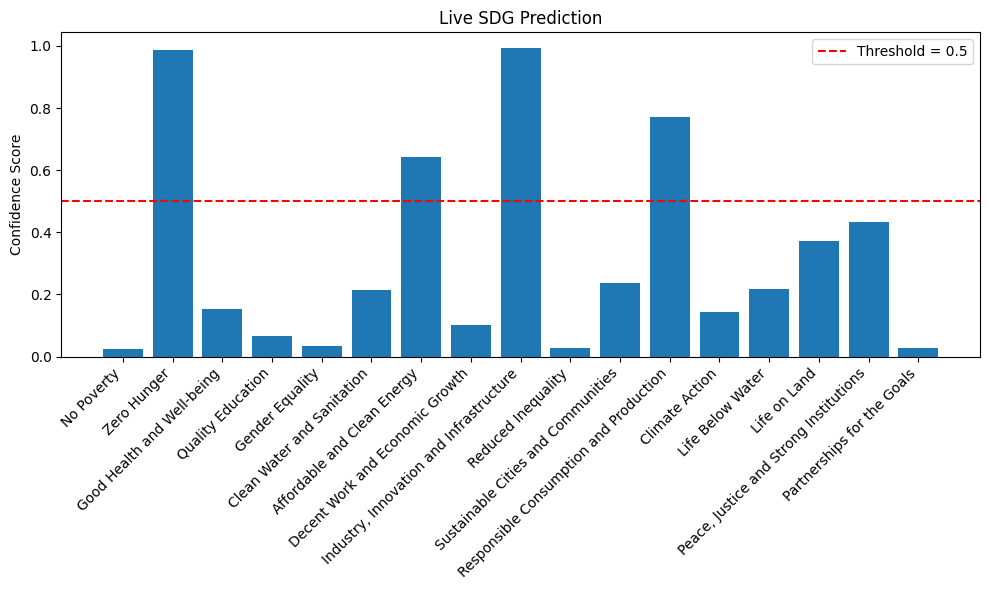

Confidence Scores: [0.02281644 0.9851361  0.1527611  0.06760562 0.03547552 0.21408801
 0.6438235  0.10232937 0.99390453 0.0290891  0.23828295 0.7700089
 0.14474683 0.21768613 0.37036908 0.43209654 0.02654655]
Binarized Predictions: [0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0]


In [21]:
# ---------- Example Usage: Live Prediction ---------- #
sample_text = "The disclosed method employs an artificial intelligence algorithm trained on hyperspectral imagery and soil data to detect early signs of disease in crops. This patent includes a drone-based platform equipped with multispectral cameras and real-time processing units to alert farmers of at-risk zones. The invention enhances agricultural yield by enabling precision intervention and minimizing the use of chemical pesticides."
probabilities, binary_predictions = live_prediction(sample_text)
print("Confidence Scores:", probabilities)
print("Binarized Predictions:", binary_predictions)


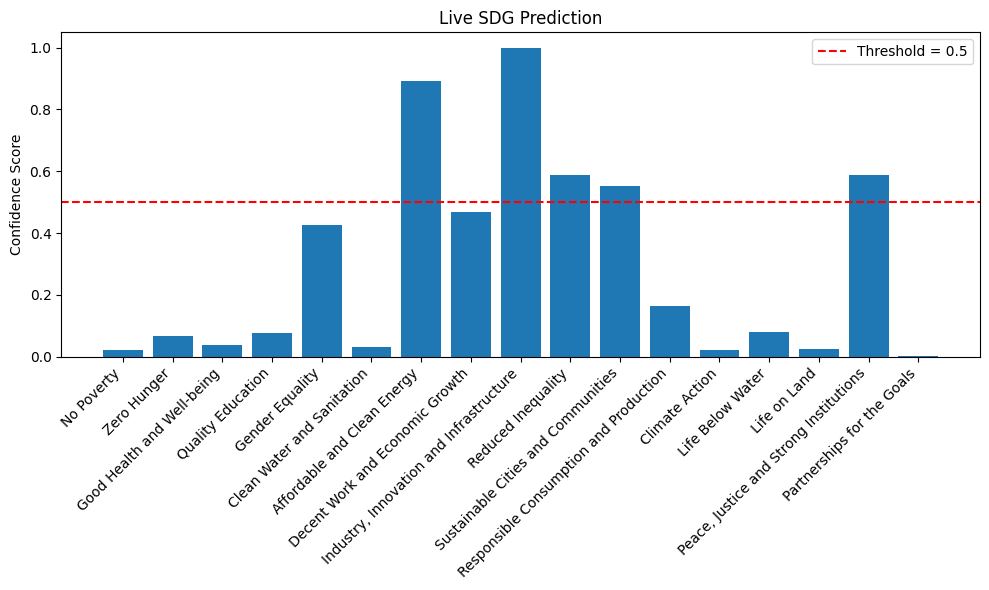

Confidence Scores: [2.2509262e-02 6.5464817e-02 3.7734717e-02 7.7866204e-02 4.2741898e-01
 3.2285068e-02 8.9172590e-01 4.6958274e-01 9.9979967e-01 5.8797628e-01
 5.5264103e-01 1.6248558e-01 1.9879738e-02 8.0360338e-02 2.3913402e-02
 5.8787167e-01 9.0341538e-04]
Binarized Predictions: [0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0]


In [22]:
# ---------- Example Usage: Live Prediction ---------- #
sample_text = "A decentralized blockchain-based financial platform enabling secure, low-cost cross-border remittance services tailored for unbanked rural women. The system leverages biometric authentication and offline transaction caching to ensure accessibility in low-connectivity areas. This innovation reduces dependency on traditional financial intermediaries and promotes financial independence among marginalized populations."
probabilities, binary_predictions = live_prediction(sample_text)
print("Confidence Scores:", probabilities)
print("Binarized Predictions:", binary_predictions)


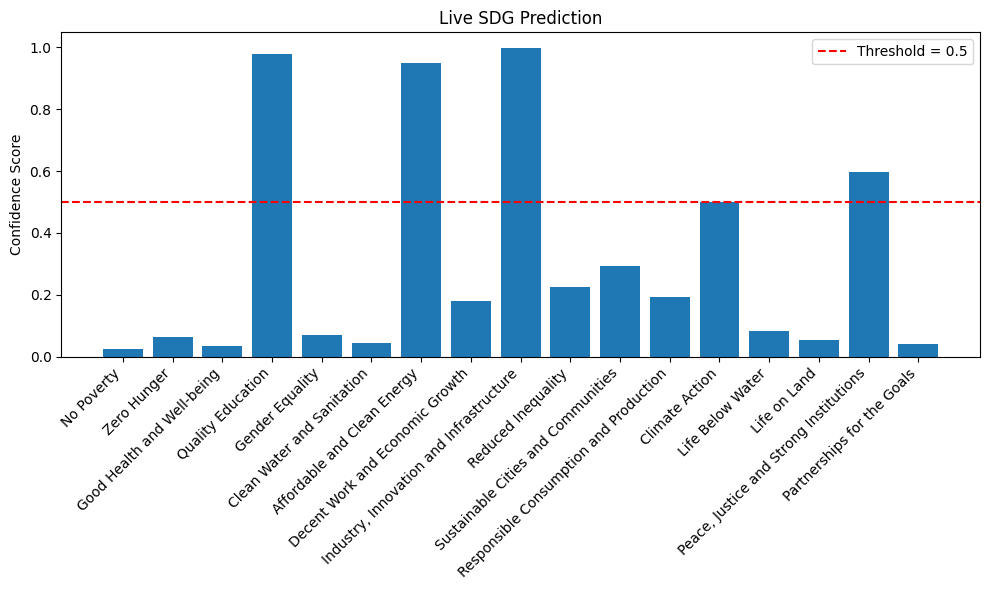

Confidence Scores: [0.02512126 0.06393036 0.03523201 0.97688454 0.06975827 0.04386293
 0.95076865 0.18090968 0.99854654 0.22526298 0.29201013 0.19163166
 0.49821326 0.08133932 0.05483086 0.5979319  0.04207627]
Binarized Predictions: [0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0]


In [23]:
# ---------- Example Usage: Live Prediction ---------- #
sample_text = "A modular, low-power smart classroom kit designed for deployment in rural or underserved regions. The kit includes a solar-powered projector, preloaded educational content in multiple languages, and a satellite-connected digital whiteboard for live interactive sessions. Its open-source hardware and curriculum partnerships enable governments and NGOs to adapt the platform to local educational goals."
probabilities, binary_predictions = live_prediction(sample_text)
print("Confidence Scores:", probabilities)
print("Binarized Predictions:", binary_predictions)


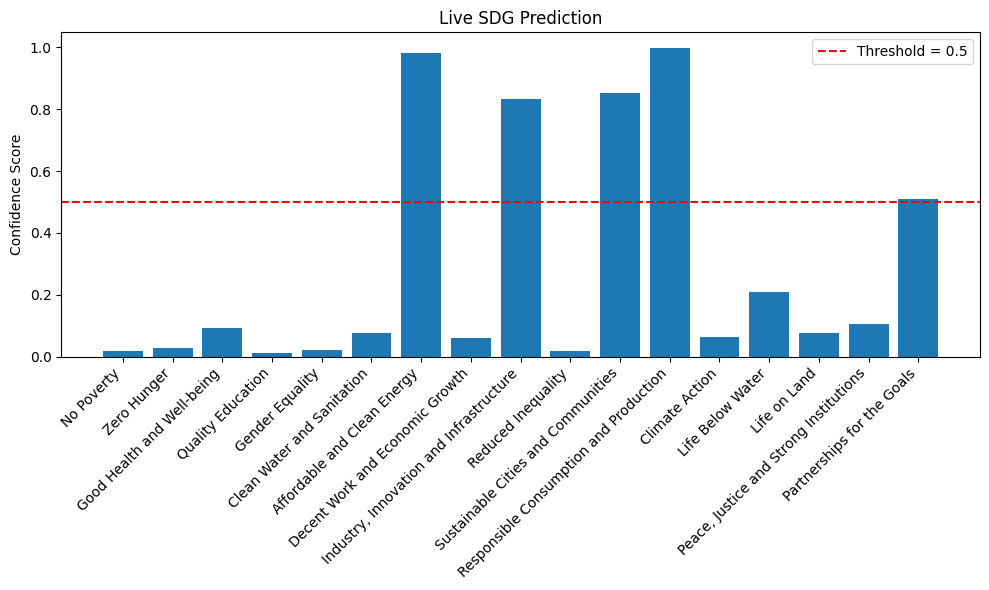

Confidence Scores: [0.01759605 0.02775638 0.09217151 0.01104082 0.0212158  0.07633457
 0.98295367 0.05848934 0.8322689  0.0171171  0.8517539  0.998895
 0.06268818 0.20835407 0.07532592 0.10436609 0.5082875 ]
Binarized Predictions: [0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1]


In [24]:
# ---------- Example Usage: Live Prediction ---------- #
sample_text = "The invention relates to a novel biodegradable polymer derived from post-extraction algae biomass, traditionally discarded as industrial waste. The biopolymer is suitable for producing food-grade packaging materials with high tensile strength and moisture resistance. The product fully decomposes in soil or marine environments within 90 days, reducing plastic pollution and closing the loop on algal biofuel production waste streams."
probabilities, binary_predictions = live_prediction(sample_text)
print("Confidence Scores:", probabilities)
print("Binarized Predictions:", binary_predictions)
